# Problem statement.

Kaggle competition @
https://www.kaggle.com/center-for-policing-equity/data-science-for-good

How do you measure justice? And how do you solve the problem of racism in policing? We look for factors that drive racial disparities in policing by analyzing census and police department deployment data. The ultimate goal is to inform police agencies where they can make improvements by identifying deployment areas where racial disparities exist and are not explainable by crime rates and poverty levels.


### Exploring Data
Dataset consists of 19 departmentwise folder. Each department folder has.  
1. One subfolder containing shapefiles of police departments.  
2. Other subfolder has ACS socio-economic data.  
3. A file with police records for incidents/crimes.  

Quick scan of files and as also specified in the problem statement, data is not consistent/uniform accross folders. Also geospatial data(coordinates) does not seem to follow same standards even within a department data.  

Using geopandas, pandas, shapely and matplotlib libraries for geospatial and tabular data wrangling and basic matplotlib for plotting.

In [1]:
#Load libraries needed for the solution
%matplotlib inline
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

First folder choosen for solution is dept_24_00098 which is Ramsey County in MN.

## Dept_24-00098 - Ramsey County Minnesota.

In [2]:
def metadata_summary(file_path):
    ''' Function to summarise metadata file. The file has components of meta data seperated by _ in code and ; in description.
    It returns unique combinations of code and description part. This will help in grouping and extracting only needed columns
    from data.
    Input - Metadata file path.
    Output - Dataframe with code, desc and type unique combinations
    '''
    meta_df = pd.read_csv(file_path,names = ['code','desc'])
    meta_code = meta_df['code'].str.split('_',expand = True)
    meta_desc = meta_df['desc'].str.split(';',expand = True)
    temp_df = pd.DataFrame(columns = ['code','desc','type'])
    for cols in meta_code.columns:
        t = pd.concat([meta_code[cols], meta_desc[cols]], axis=1)
        t['type'] = 'type'+str(cols)
        t.columns = ['code','desc','type']
        temp_df = pd.concat([temp_df,t],axis=0)

    temp_df.drop_duplicates(inplace = True)
    temp_df.dropna(subset = ['code','desc'],inplace = True)
    temp_df.reset_index(inplace = True, drop = True)
    return(temp_df)

In [3]:
def cleveland_plot(xmins, xmaxs, ylabs, chart_title, xmin_lab, xmax_lab,xtitle, ytitle, fsize=(10,10)):
    ''' Plot a cleveland plot showing the xmin and xmax for a set of categorical variable'''
    tot_recs = 10 if len(xmins) > 30 else len(xmins)
    y_range = np.arange(1,tot_recs+1)

    fig, ax = plt.subplots(figsize=fsize)
    plt.hlines(y = y_range, xmin = xmins[:tot_recs], xmax = xmaxs[:tot_recs], 
               alpha=0.3, color='gray', linewidth = 2)
    plt.scatter(x = xmins[:tot_recs],  y = y_range, color = 'green', label = xmin_lab, s =50, marker='o')
    plt.scatter(x = xmaxs[:tot_recs],  y = y_range, color = 'red', label = xmax_lab, s = 50,marker = 'H')
    plt.yticks(y_range, ylabs[:tot_recs],fontsize=12)
    plt.ylabel(ytitle, fontsize = 14, color = 'gray')
    plt.ylim(tot_recs+1,0)
    plt.xticks(fontsize=12)
    plt.xlabel(xtitle, fontsize = 14, color = 'gray')
    plt.legend(fontsize = 12,loc='best')
    plt.title(chart_title, fontsize = 18)
    plt.grid(False)
    ax.set_facecolor('white')
    fig.set_facecolor('w')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

## Preparing Police_records_mn for gender, race bias

Create a summary of police records to get totals by gender, race to calculate percentage of vehicle stoppages by subjects' race and gender.

In [4]:
base_path = 'input/'
police_records_mn = pd.read_csv(base_path+'Dept_24-00098/24-00098_Vehicle-Stops-data.csv',
                            skiprows=[1])
police_records_mn.shape

(710472, 12)

In [5]:
police_records_mn.head()

,INCIDENT_DATE_YEAR,INCIDENT_DATE,SUBJECT_RACE,SUBJECT_GENDER,SEARCH_CONDUCTED_PERSON,SEARCH_CONDUCTED_VEHICLE,SUBJECT_ISSUED_CITATION,SUBJECT_AGE,INCIDENT_REASON,LOCATION_DISTRICT,LOCATION_LATITUDE,LOCATION_LONGITUDE
0,2001,1/1/01 0:11,White,Female,No,No,No,NaN,No Data,55.0,44.973917,-93.060895
1,2001,1/1/01 0:14,White,Male,No,No,No,NaN,No Data,106.0,44.952118,-93.151733
2,2001,1/1/01 0:23,White,Male,No,No,No,NaN,No Data,58.0,44.973888,-93.030391
3,2001,1/1/01 0:28,White,Male,No,No,No,NaN,No Data,44.0,44.973588,-93.172152
4,2001,1/1/01 0:30,Asian,Female,Yes,No,No,NaN,No Data,95.0,44.959878,-93.060945


Police records have reported vehicle stops from 2001 onwards. More than 710K records.  
subject race, gender, Age(there seems many missing records for this) will dictate ACS data extraction subsequently for analysis. Geospatially it has long/lat in decimal degrees.  
To make it geospatial data, long/lat is used to create geometry which is of type 'Point'. Long/Lat in decimal degrees in **epsg:4326.**  
CRS needs to be set first before converting to common CRS as above using gpd inbuilt functions.

In [6]:
# Missing long/lat will error out. Hence these are dropped.
# create long/lat point, set correct CRS it represented in then convert to common CRS used in this solution.
police_records_mn.dropna(subset = ['LOCATION_LONGITUDE','LOCATION_LATITUDE'],inplace = True)
police_records_mn['geometry'] = list(zip(police_records_mn['LOCATION_LONGITUDE'],police_records_mn['LOCATION_LATITUDE']))
police_records_mn['geometry'] = police_records_mn['geometry'].apply(Point)
police_records_mn = gpd.GeoDataFrame(police_records_mn,
                                 geometry = 'geometry',
                                 crs ={'init': 'epsg:4326'} )

In [7]:
police_records_mn.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 709765 entries, 0 to 710471
Data columns (total 13 columns):
INCIDENT_DATE_YEAR          709765 non-null int64
INCIDENT_DATE               709765 non-null object
SUBJECT_RACE                709765 non-null object
SUBJECT_GENDER              709765 non-null object
SEARCH_CONDUCTED_PERSON     709765 non-null object
SEARCH_CONDUCTED_VEHICLE    709765 non-null object
SUBJECT_ISSUED_CITATION     709765 non-null object
SUBJECT_AGE                 100508 non-null float64
INCIDENT_REASON             709765 non-null object
LOCATION_DISTRICT           709765 non-null float64
LOCATION_LATITUDE           709765 non-null float64
LOCATION_LONGITUDE          709765 non-null float64
geometry                    709765 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 75.8+ MB


In [8]:
police_records_mn.crs

{'init': 'epsg:4326'}

In [9]:
police_records_mn.head()

,INCIDENT_DATE_YEAR,INCIDENT_DATE,SUBJECT_RACE,SUBJECT_GENDER,SEARCH_CONDUCTED_PERSON,SEARCH_CONDUCTED_VEHICLE,SUBJECT_ISSUED_CITATION,SUBJECT_AGE,INCIDENT_REASON,LOCATION_DISTRICT,LOCATION_LATITUDE,LOCATION_LONGITUDE,geometry
0,2001,1/1/01 0:11,White,Female,No,No,No,NaN,No Data,55.0,44.973917,-93.060895,POINT (-93.06089457 44.97391713)
1,2001,1/1/01 0:14,White,Male,No,No,No,NaN,No Data,106.0,44.952118,-93.151733,POINT (-93.15173337 44.95211807)
2,2001,1/1/01 0:23,White,Male,No,No,No,NaN,No Data,58.0,44.973888,-93.030391,POINT (-93.03039075 44.9738881)
3,2001,1/1/01 0:28,White,Male,No,No,No,NaN,No Data,44.0,44.973588,-93.172152,POINT (-93.17215188 44.97358832)
4,2001,1/1/01 0:30,Asian,Female,Yes,No,No,NaN,No Data,95.0,44.959878,-93.060945,POINT (-93.06094546 44.95987773)


In [10]:
# to get total count by grid num
pr_summary_mn = pd.DataFrame(police_records_mn['LOCATION_DISTRICT'].value_counts()).reset_index()
pr_summary_mn.columns = ['gridnum', 'total_stops']

In [11]:
# get totals by gender of stoppages
t = pd.DataFrame(police_records_mn.groupby(by = ['LOCATION_DISTRICT','SUBJECT_GENDER']).size()).reset_index()
t.columns = ['gridnum','gender','stops']
t = t.pivot_table(values = 'stops',index = 'gridnum', columns = 'gender', fill_value = 0).reset_index()
t.rename(columns = {'No Data':'gender_missing', 'Female' : 'female_stops', 'Male':'male_stops'},inplace = True)
pr_summary_mn = pr_summary_mn.merge(t, how = 'left', on = 'gridnum')

In [12]:
# get totals by race of drivers
t = pd.DataFrame(police_records_mn.groupby(by = ['LOCATION_DISTRICT','SUBJECT_RACE']).size()).reset_index()
t.columns = ['gridnum','race','stops']
t['race'] = t['race'].str.lower()
t['race'] = t['race'].str.replace(' ','_')
t = t.pivot_table(values = 'stops',index = 'gridnum', columns = 'race', fill_value = 0).reset_index()
t['native_american'] = t['native_am'] + t['native_american']
t['other'] = t['other'] + t['no_data']
t.drop(columns = ['native_am','no_data'],inplace = True)
pr_summary_mn = pr_summary_mn.merge(t, how = 'left', on = 'gridnum')

In [13]:
# Calculate percentage columns
pr_summary_mn.sort_values(by = 'gridnum',inplace=True)
pr_summary_mn.reset_index(inplace = True,drop=True)
pr_summary_mn['female_stop_per'] = pr_summary_mn['female_stops']/(pr_summary_mn['female_stops'] + pr_summary_mn['male_stops'])*100
pr_summary_mn['male_stop_per'] = pr_summary_mn['male_stops']/(pr_summary_mn['female_stops'] + pr_summary_mn['male_stops'])*100
pr_summary_mn['asian_stop_per'] = pr_summary_mn['asian']/pr_summary_mn['total_stops']*100
pr_summary_mn['black_stop_per'] = pr_summary_mn['black']/pr_summary_mn['total_stops']*100
pr_summary_mn['latino_stop_per'] = pr_summary_mn['latino']/pr_summary_mn['total_stops']*100
pr_summary_mn['native_american_stop_per'] = pr_summary_mn['native_american']/pr_summary_mn['total_stops']*100
pr_summary_mn['other_stop_per'] = pr_summary_mn['other']/pr_summary_mn['total_stops']*100
pr_summary_mn['white_stop_per'] = pr_summary_mn['white']/pr_summary_mn['total_stops']*100
pr_summary_mn['gridnum'] = pr_summary_mn['gridnum'].astype(int)
pr_summary_mn.head(3)

,gridnum,total_stops,female_stops,male_stops,gender_missing,asian,black,latino,native_american,other,white,female_stop_per,male_stop_per,asian_stop_per,black_stop_per,latino_stop_per,native_american_stop_per,other_stop_per,white_stop_per
0,1,652,124,272,256,19,95,9,3,263,263,31.313131,68.686869,2.914110,14.570552,1.380368,0.460123,40.337423,40.337423
1,2,95,32,40,23,4,6,2,1,29,53,44.444444,55.555556,4.210526,6.315789,2.105263,1.052632,30.526316,55.789474
2,5,521,165,286,70,19,78,11,1,78,334,36.585366,63.414634,3.646833,14.971209,2.111324,0.191939,14.971209,64.107486


## Read police precinct shapefiles.

In [14]:
pp_mn_geo = gpd.read_file(base_path + 'Dept_24-00098/24-00098_Shapefiles/StPaul_geo_export_6646246d-0f26-48c5-a924-f5a99bb51c47.shp')
pp_mn_geo.crs

{'init': 'epsg:4326'}

In [15]:
pp_mn_geo.describe()

,dist,gridnum,geometry
count,200,200,200
unique,3,200,200
top,Western District,104,POLYGON ((-93.08894531060976 44.98455066510067...
freq,88,1,1


In [16]:
pp_mn_geo.head(3)

,dist,gridnum,geometry
0,Western District,82,POLYGON ((-93.18731873325051 44.95984522374139...
1,Western District,62,"POLYGON ((-93.1891517284332 44.96150365239401,..."
2,Western District,43,POLYGON ((-93.18726521154463 44.97865486589834...


Police precinct has 200 records, geometry in **epsg:4326** coordinate reference system.  

Now overlay vehicle stops data on police precinct map.

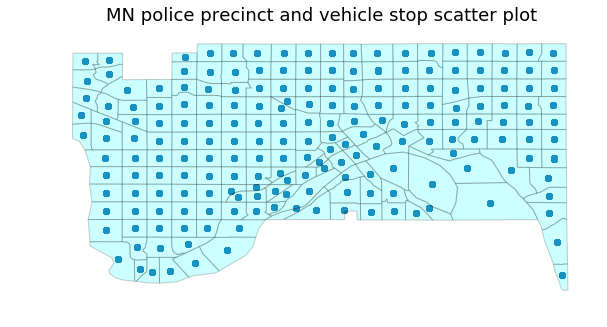

In [17]:
ax = police_records_mn.plot(figsize=(10,10))
pp_mn_geo.plot(ax=ax,facecolor = 'cyan',edgecolor = 'black', alpha=0.2)
ax.set_title('MN police precinct and vehicle stop scatter plot', fontsize=18)
ax.set_axis_off()

This is bit unexpected chart!!  
I was expecting vehicle stops to be spread accross geospatilly. Upon further study of data, it seems all long/lat provided are 'center' of police precinct rather than actual long/lat of incidents similar to police records in other departments data.  
This chart won't depict *hot zones* of vehicle stop activities.  

Let's make use of **bubble chart.**  

For this we need center of police precincts and count of stops. So we need to *merge pp_mn_geo* with *pr_summary_mn*

In [18]:
pp_mn_geo['center'] = pp_mn_geo['geometry'].centroid
pp_mn_geo['gridnum'] = pp_mn_geo['gridnum'].astype(int)
pp_pr_summary_mn = pd.merge(pp_mn_geo, pr_summary_mn, on = 'gridnum', how = 'inner')

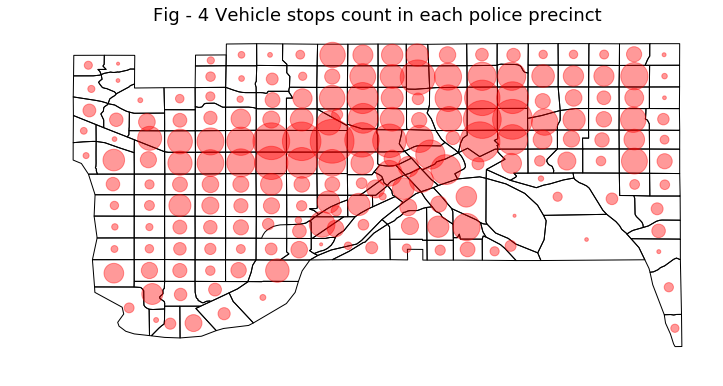

In [19]:
ax = pp_pr_summary_mn.plot(facecolor = 'None', edgecolor = 'black',figsize = (12,12))
plt.scatter(x=pp_pr_summary_mn['center'].apply(lambda x: Point(x).x),
           y=pp_pr_summary_mn['center'].apply(lambda x: Point(x).y),
           s = (pp_pr_summary_mn['total_stops']/10),
           alpha=0.4,
           c='red')
ax.set_title('Fig - 4 Vehicle stops count in each police precinct', fontsize =18)
ax.set_axis_off()

IT shows *hot zones* are clustered around center of the map. Peripheries seem to be less vehicle stops.  

How these precincts compare to different percentages calculated above. Use **choropleth** maps.

In [20]:
def choropleth_map(df, c, fsize = (6,6)):
    ax = df.plot(column = c, legend=True, figsize=fsize, cmap = 'Oranges', scheme = 'quantiles')
    ax.set_title('Map - ' +c, fontsize=16)
    ax.get_legend().set_bbox_to_anchor((1.4,1.2))
    ax.set_axis_off()

C:\Users\vandaleesh\Anaconda3\envs\folium on python3\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)
C:\Users\vandaleesh\Anaconda3\envs\folium on python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


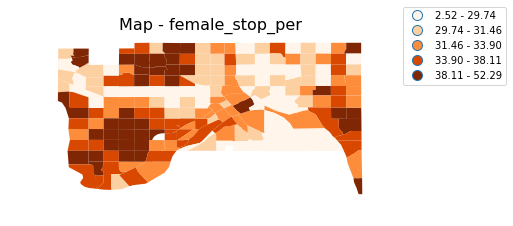

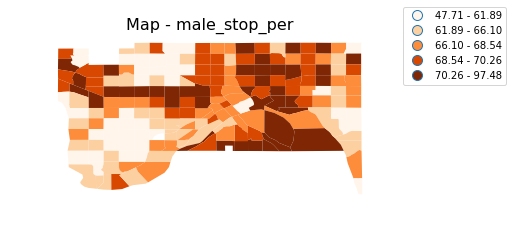

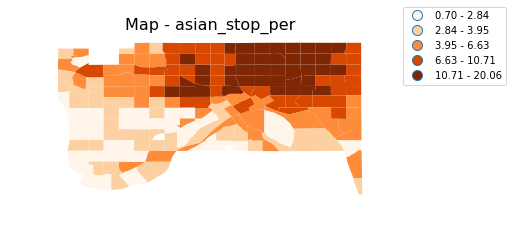

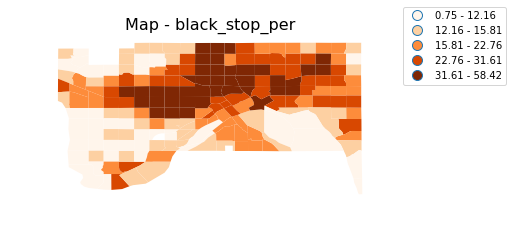

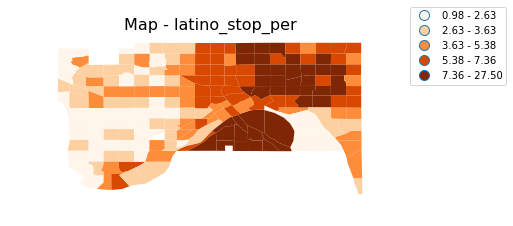

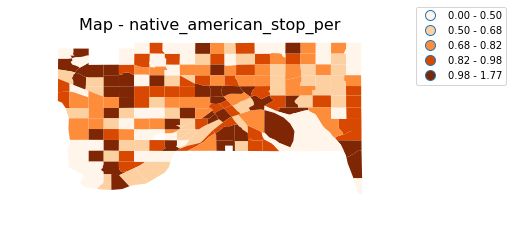

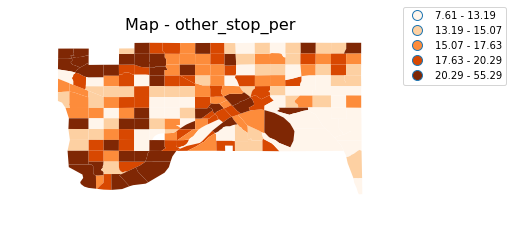

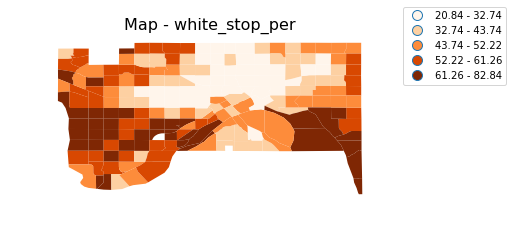

In [21]:
# plot the choropleth from per columns.
for cl in pp_pr_summary_mn.iloc[:,14:].columns:
    choropleth_map(pp_pr_summary_mn, cl)

Key observations from above choropleth maps are  
1. Male driver stops are higher than female driver dtops. Range for Male driver stops is 50 to 90%. Female drivers are in the range of 10 to 50%. There is one police precinct in south where almost 100% stops are male drivers.  
2. Vehicle stop by race has distinct clustering geospatially. Also they range is different accross the data set. Native american stops range up to 1.6%, asians range up to 20% and latinos range up to 25%. Black and white race vehicle stops range up to 80% and above.  
3. Top % of vehicle stops by cluster geospatially. White almost except central part of the map. Latino stops are in south central region, black in central part of the map and asian north east part of the map.

## Read ACS Data.  
ACS folder has subfolders for  
1. education  
2. education over 25  
3. poverty  
4. race-sex-age  
5. income  
6. employment  
7. housing.  

Each folder has metadata and the actual data. Meta data shows number of columns ranges in 700-800 count. Also they are not uniform accross different departments. There is need to systematically process the metadata.

In [22]:
def metadata_summary(file_path):
    ''' Function to summarise metadata file. The file has components of meta data seperated by _ in code and ; in description.
    It returns unique combinations of code and description part. This will help in grouping and extracting only needed columns
    from data.
    Input - Metadata file path.
    Output - Dataframe with code, desc and type unique combinations
    '''
    meta_df = pd.read_csv(file_path,names = ['code','desc'])
    meta_code = meta_df['code'].str.split('_',expand = True)
    meta_desc = meta_df['desc'].str.split(';',expand = True)
    temp_df = pd.DataFrame(columns = ['code','desc','type'])
    for cols in meta_code.columns:
        t = pd.concat([meta_code[cols], meta_desc[cols]], axis=1)
        t['type'] = 'type'+str(cols)
        t.columns = ['code','desc','type']
        temp_df = pd.concat([temp_df,t],axis=0)

    temp_df.drop_duplicates(inplace = True)
    temp_df.dropna(subset = ['code','desc'],inplace = True)
    temp_df.reset_index(inplace = True, drop = True)
    return(temp_df)

**Race Sex Age folder.**

In [23]:
rsa_mn_path = base_path + 'Dept_24-00098/24-00098_ACS_data/24-00098_ACS_race-sex-age/ACS_15_5YR_DP05_metadata.csv'
rsa_meta_mn = metadata_summary(rsa_mn_path)
rsa_meta_mn.head()

,code,desc,type
0,GEO.id,Id,type0
1,GEO.id2,Id2,type0
2,GEO.display-label,Geography,type0
3,HC01,Estimate,type0
4,HC02,Margin of Error,type0


HC01 is estimate parameter. VC03, VC04 and VC05 are total population, male and female. So to answer gender bias below columns will be extracted.  
1. HC01_VC03 - Total population
2. HC01_VC04 - Total male
3. HC01_VC05 - Total female  

To get Race data, let's filter out metadata by description containing RACE -  column.

In [24]:
rsa_meta_mn[rsa_meta_mn.desc.str.contains('RACE - One race')]

,code,desc,type
37,VC48,RACE - One race,type1
38,VC49,RACE - One race - White,type1
39,VC50,RACE - One race - Black or African American,type1
40,VC51,RACE - One race - American Indian and Alaska ...,type1
41,VC52,RACE - One race - American Indian and Alaska ...,type1
42,VC53,RACE - One race - American Indian and Alaska ...,type1
43,VC54,RACE - One race - American Indian and Alaska ...,type1
44,VC55,RACE - One race - American Indian and Alaska ...,type1
45,VC56,RACE - One race - Asian,type1
46,VC57,RACE - One race - Asian - Asian Indian,type1


From above list, we need to extract below for one - race.  
1. HC01_VC49 - white.  
2. HC01_VC50 - black.  
3. HC01_VC56 - asian.  

In [25]:
# Read race_sex_age data
rsa_mn_data = pd.read_csv(base_path + 'Dept_24-00098/24-00098_ACS_data/24-00098_ACS_race-sex-age/ACS_15_5YR_DP05_with_ann.csv',
           skiprows = [1], na_values = '-')
rsa_mn_data.head(3)

,GEO.id,GEO.id2,GEO.display-label,HC01_VC03,HC02_VC03,HC03_VC03,HC04_VC03,HC01_VC04,HC02_VC04,HC03_VC04,...,HC03_VC108,HC04_VC108,HC01_VC109,HC02_VC109,HC03_VC109,HC04_VC109,HC01_VC110,HC02_VC110,HC03_VC110,HC04_VC110
0,1400000US27123030100,27123030100,"Census Tract 301, Ramsey County, Minnesota",4872,452,4872,(X),2323,440,47.7,...,3416,(X),1658,451,48.5,7.3,1758,193,51.5,7.3
1,1400000US27123030201,27123030201,"Census Tract 302.01, Ramsey County, Minnesota",5303,328,5303,(X),2381,274,44.9,...,4134,(X),1909,221,46.2,4.3,2225,197,53.8,4.3
2,1400000US27123030202,27123030202,"Census Tract 302.02, Ramsey County, Minnesota",2120,182,2120,(X),897,150,42.3,...,1857,(X),794,138,42.8,5.5,1063,130,57.2,5.5


In [26]:
acs_mn_data = rsa_mn_data.filter(items = ['GEO.id','HC01_VC03','HC01_VC04','HC01_VC05','HC01_VC49','HC01_VC50','HC01_VC56'])
acs_mn_data.rename(columns = {'HC01_VC03':'tot_pop',
                              'HC01_VC04':'male_pop',
                              'HC01_VC05':'female_pop',
                              'HC01_VC49':'race_white',
                              'HC01_VC50':'race_black',
                              'HC01_VC56':'race_asian'}, inplace = True)

## education data.  

There are 2 folders for education. Education and Education over 25. As the police records are only for vehicle stoppages, and drivers supposed to be 17 and above. I will use Education folder and select appropriate columns. Ignoring education over 25 folder.

In [27]:
ea_mn_path = base_path + 'Dept_24-00098/24-00098_ACS_data/24-00098_ACS_education-attainment/ACS_15_5YR_S1501_metadata.csv'
ea_meta_mn = metadata_summary(ea_mn_path)
ea_meta_mn.head()

,code,desc,type
0,GEO.id,Id,type0
1,GEO.id2,Id2,type0
2,GEO.display-label,Geography,type0
3,HC01,Total,type0
4,HC02,Percent,type0


From the metadata summary, HC01 is total and EST is estimates. So columns starting with HC01_EST are needed.  
VC02 + VC08 will give total population 18 + which is legal driver age.  
We will use High school and above and 'more educated' and less than high school educated as less educated.  
1. HC01_EST_VC02 + HC01_EST_VC08 = 'edu_pop_tot'  
2. HC01_EST_VC03 + HC01_EST_VC09 + HC01_EST_VC10 = 'edu_pop_less'  

In [28]:
# Read education_attainment
ea_mn_data = pd.read_csv(base_path + 'Dept_24-00098/24-00098_ACS_data/24-00098_ACS_education-attainment/ACS_15_5YR_S1501_with_ann.csv',
           skiprows = [1], na_values = '-')
ea_mn_data = ea_mn_data.filter(items = ['GEO.id','HC01_EST_VC02', 'HC01_EST_VC08','HC01_EST_VC03' ,'HC01_EST_VC09', 'HC01_EST_VC10'])
ea_mn_data['edu_pop_tot'] = ea_mn_data['HC01_EST_VC02'] + ea_mn_data['HC01_EST_VC08']
ea_mn_data['edu_pop_less'] = ea_mn_data['HC01_EST_VC03'] + ea_mn_data['HC01_EST_VC09'] + ea_mn_data['HC01_EST_VC10']
ea_mn_data = ea_mn_data.filter(items = ['GEO.id', 'edu_pop_tot','edu_pop_less'])

In [29]:
acs_mn_data = acs_mn_data.merge(ea_mn_data, on = 'GEO.id', how = 'left')
acs_mn_data.head()

,GEO.id,tot_pop,male_pop,female_pop,race_white,race_black,race_asian,edu_pop_tot,edu_pop_less
0,1400000US27123030100,4872,2323,2549,3996,175,546,3990,71
1,1400000US27123030201,5303,2381,2922,4604,379,156,4291,195
2,1400000US27123030202,2120,897,1223,1787,170,66,1904,44
3,1400000US27123030300,5458,2736,2722,4815,140,54,4235,151
4,1400000US27123030400,6640,3300,3340,3307,1368,1614,4859,1004


## Poverty data

In [30]:
p_mn_path = base_path + 'Dept_24-00098/24-00098_ACS_data/24-00098_ACS_poverty/ACS_15_5YR_S1701_metadata.csv'
p_meta_mn = metadata_summary(p_mn_path)
p_meta_mn

,code,desc,type
0,GEO.id,Id,type0
1,GEO.id2,Id2,type0
2,GEO.display-label,Geography,type0
3,HC01,Total,type0
4,HC02,Below poverty level,type0
5,HC03,Percent below poverty level,type0
6,EST,Estimate,type1
7,MOE,Margin of Error,type1
8,VC01,Population for whom poverty status is determined,type2
9,VC03,AGE - Under 18 years,type2


HC01 is total, HC02 is below poverty level, EST is estimate and VC01 is total population. So we need 2 columns only.  
1. HC01_EST_VC01 - Total population  
2. HC02_EST_VC01 - Below poverty level population  

In [31]:
# Poverty data
p_mn_data = pd.read_csv(base_path + 'Dept_24-00098/24-00098_ACS_data/24-00098_ACS_poverty/ACS_15_5YR_S1701_with_ann.csv',
           skiprows = [1], na_values = '-')
p_mn_data = p_mn_data.filter(items = ['GEO.id','HC01_EST_VC01','HC02_EST_VC01'])
p_mn_data.rename(columns = {'HC01_EST_VC01':'pov_pop_tot','HC02_EST_VC01':'pov_pop_below'},inplace = True)

In [32]:
acs_mn_data = acs_mn_data.merge(p_mn_data, on = 'GEO.id', how = 'left')
acs_mn_data

,GEO.id,tot_pop,male_pop,female_pop,race_white,race_black,race_asian,edu_pop_tot,edu_pop_less,pov_pop_tot,pov_pop_below
0,1400000US27123030100,4872,2323,2549,3996,175,546,3990,71,4431,691
1,1400000US27123030201,5303,2381,2922,4604,379,156,4291,195,4965,538
2,1400000US27123030202,2120,897,1223,1787,170,66,1904,44,2094,515
3,1400000US27123030300,5458,2736,2722,4815,140,54,4235,151,5458,364
4,1400000US27123030400,6640,3300,3340,3307,1368,1614,4859,1004,6608,1555
5,1400000US27123030500,5590,2521,3069,995,1484,2542,3460,1124,5493,2820
6,1400000US27123030601,6008,2933,3075,1237,864,3189,3978,1556,5982,2153
7,1400000US27123030602,4041,1929,2112,2719,170,938,2869,377,4021,392
8,1400000US27123030702,4989,2490,2499,3122,396,1299,3542,322,4953,590
9,1400000US27123030703,3843,1855,1988,2061,211,1361,2656,553,3843,847


## employment data.  

In [33]:
emp_mn_path = base_path + 'Dept_24-00098/24-00098_ACS_data/24-00098_ACS_employment/ACS_15_5YR_S2301_metadata.csv'
emp_meta_mn = metadata_summary(emp_mn_path)
emp_meta_mn

,code,desc,type
0,GEO.id,Id,type0
1,GEO.id2,Id2,type0
2,GEO.display-label,Geography,type0
3,HC01,Total,type0
4,HC02,Labor Force Participation Rate,type0
5,HC03,Employment/Population Ratio,type0
6,HC04,Unemployment rate,type0
7,EST,Estimate,type1
8,MOE,Margin of Error,type1
9,VC01,Population 16 years and over,type2


From above metadata summary,  EST is for estimate, (ignoring MOE margin of error). HC01 is total population and HC04 is unemplyment rate. VC01 is population 16 and above. So we need below 2 columns.  
1. HC01_EST_VC01 - 'pop_emp_tot'
2. HC04_EST_VC01 - 'pop_emp_unemploy_rate'

In [34]:
# Employment data
emp_mn_data = pd.read_csv(base_path + 'Dept_24-00098/24-00098_ACS_data/24-00098_ACS_employment/ACS_15_5YR_S2301_with_ann.csv',
           skiprows = [1], na_values = '-')
emp_mn_data = emp_mn_data.filter(items = ['GEO.id','HC01_EST_VC01','HC04_EST_VC01'])
emp_mn_data.rename(columns = {'HC01_EST_VC01':'pop_emp_tot','HC04_EST_VC01':'pop_emp_unemploy_rate'},inplace = True)

In [35]:
acs_mn_data = acs_mn_data.merge(emp_mn_data, on = 'GEO.id', how = 'left')

## Income.  
It has median income per household for various categories as census track level. However we need to roll it up to police precinct level. We can't really use median values to rollup/divide to police precinct level. So can't make use of this data.  


## Occupied housing units.  

In [36]:
ooh_mn_path = base_path + 'Dept_24-00098/24-00098_ACS_data/24-00098_ACS_owner-occupied-housing/ACS_15_5YR_S2502_metadata.csv'
ooh_meta_mn = metadata_summary(ooh_mn_path)
ooh_meta_mn

,code,desc,type
0,GEO.id,Id,type0
1,GEO.id2,Id2,type0
2,GEO.display-label,Geography,type0
3,HC01,Occupied housing units,type0
4,HC02,Owner-occupied housing units,type0
5,HC03,Renter-occupied housing units,type0
6,EST,Estimate,type1
7,MOE,Margin of Error,type1
8,VC01,Occupied housing units,type2
9,VC04,RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHO...,type2


From above metadata summary we will extract EST estimate, HC01 occupied housing units, HC02 owner occupied and VC01 for occupied housing units. So we will extract below 2 columns.  
1. HC01_EST_VC01 - 'occupied_units'  
2. HC02_EST_VC01 - 'owner_occupied_units'


In [37]:
# Employment data
ooh_mn_data = pd.read_csv(base_path + 'Dept_24-00098/24-00098_ACS_data/24-00098_ACS_owner-occupied-housing/ACS_15_5YR_S2502_with_ann.csv',
           skiprows = [1], na_values = '-')
ooh_mn_data = ooh_mn_data.filter(items = ['GEO.id','HC01_EST_VC01','HC02_EST_VC01'])
ooh_mn_data.rename(columns = {'HC01_EST_VC01':'occupied_units','HC02_EST_VC01':'owner_occupied_units'},inplace = True)

In [38]:
acs_mn_data = acs_mn_data.merge(ooh_mn_data, on = 'GEO.id', how = 'left')
acs_mn_data['pop_emp_unemployed_count'] = acs_mn_data['pop_emp_tot'] * acs_mn_data['pop_emp_unemploy_rate']/100
acs_mn_data.drop(columns = ['pop_emp_unemploy_rate'], inplace = True)
acs_mn_data.head(3)

,GEO.id,tot_pop,male_pop,female_pop,race_white,race_black,race_asian,edu_pop_tot,edu_pop_less,pov_pop_tot,pov_pop_below,pop_emp_tot,occupied_units,owner_occupied_units,pop_emp_unemployed_count
0,1400000US27123030100,4872,2323,2549,3996,175,546,3990,71,4431,691,4077,1797,983,179.388
1,1400000US27123030201,5303,2381,2922,4604,379,156,4291,195,4965,538,4476,2197,1386,295.416
2,1400000US27123030202,2120,897,1223,1787,170,66,1904,44,2094,515,1915,1074,139,45.960


## Adding geospatial data to ACS data.

census.gov website has geospatial data for each of the states. 
Minnesota state census tracks shapefiles are downloaded from  
https://www.census.gov/geo/maps-data/data/cbf/cbf_tracts.html  

In [39]:
# read the census track data and inspect first few rows
#base_path = '../input/cpe-data/' for kaggle
census_tracks_mn = gpd.read_file(base_path+'mncensustracks/cb_2017_27_tract_500k.shp')
census_tracks_mn.head(2)

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,27,003,050208,1400000US27003050208,27003050208,502.08,CT,5687364,393200,"POLYGON ((-93.35732899999999 45.219614, -93.33..."
1,27,003,050232,1400000US27003050232,27003050232,502.32,CT,5504435,779522,"POLYGON ((-93.08155699999999 45.174834, -93.07..."


In [40]:
census_tracks_mn.crs

{'init': 'epsg:4269'}

CRS of census tracks to be converted to **epsg:4326** in order to be able to merge with police precinct geospatially.

In [41]:
census_tracks_mn.to_crs(pp_mn_geo.crs, inplace = True)

In [42]:
acs_mn_data_geo = census_tracks_mn[['AFFGEOID','geometry']].merge(acs_mn_data,
                                                                  right_on = 'GEO.id',
                                                                  left_on = 'AFFGEOID', 
                                                                  how = 'right')

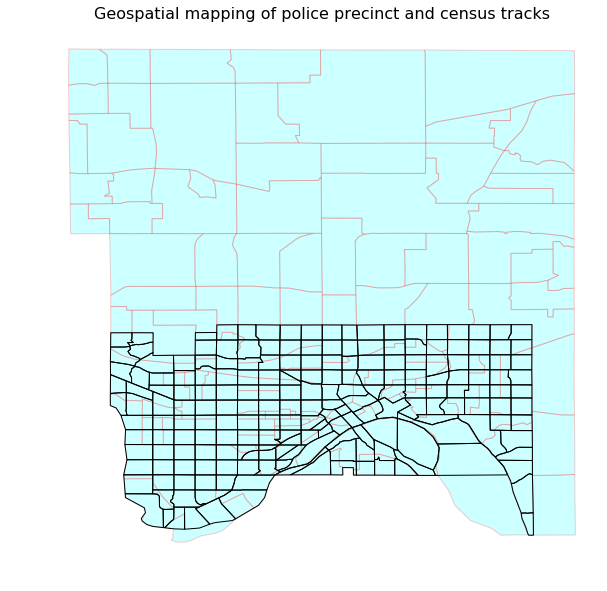

In [43]:
ax = acs_mn_data_geo.plot(color = 'cyan', alpha = 0.2, edgecolor = 'red', figsize=(10,10))
pp_mn_geo.plot(ax= ax, facecolor = 'None', edgecolor = 'black')
ax.set_title('Geospatial mapping of police precinct and census tracks',fontsize=16)
ax.set_axis_off()

census track and police presinct CRS unit is degrees in decimals. I am choosing a CRS with unit of measure in Meters. Rational further in the solution, there would be need for calculating area/distance, so these measures in meters/sq meters is sensible rather than degrees. Using EPSG:32118 CRS system.  

More details from https://epsg.io/32118  

Using geopandas to_crs function to convert to same CRS.

In [44]:
# area for geodf with units in degrees is very small number. We need to get % split to be applied by taking the ratio.
# This can cause big rounding errors. So side effect of converting degrees to meters is sq.meters is much bigger number, 
# reducing the rounding error.

pp_mn_geo.to_crs({'init': 'epsg:32118', 'no_defs': True},inplace = True)
pp_mn_geo['area_pp'] = pp_mn_geo['geometry'].area
acs_mn_data_geo.to_crs({'init': 'epsg:32118', 'no_defs': True},inplace = True)
acs_mn_data_geo['area_acs'] = acs_mn_data_geo['geometry'].area

In [45]:
# overlay census polygons on police precincts. Overlap area / census track area will give split % to be applied to 
# acs data before rolling up.
pp_acs_mn = gpd.overlay(pp_mn_geo[['gridnum','geometry','area_pp']], 
                           acs_mn_data_geo[['AFFGEOID','geometry','area_acs']], 
                           how = 'intersection')

In [46]:
pp_acs_mn.to_csv('input/pp_acs_mn.csv')

In [47]:
pp_acs_mn['common_area'] = pp_acs_mn['geometry'].area
pp_acs_mn['overlap_per'] = pp_acs_mn['common_area']/pp_acs_mn['area_acs']*100 
pp_acs_mn = pp_acs_mn.filter(items = ['gridnum','AFFGEOID','overlap_per'])
pp_acs_mn

,gridnum,AFFGEOID,overlap_per
0,280,1400000US27123042503,7.068880e-02
1,280,1400000US27123037403,6.930067e+00
2,240,1400000US27123037403,2.174198e+01
3,240,1400000US27123042503,1.164885e-07
4,240,1400000US27123042504,1.067881e-08
5,200,1400000US27123037403,1.808370e+01
6,243,1400000US27123037601,9.810459e+00
7,244,1400000US27123037602,8.303922e+00
8,244,1400000US27123037601,9.598809e-02
9,243,1400000US27123037602,2.832199e-05


In [48]:
# acs data merged with pp and asc overlap dataframe.

pp_by_acs_data = pp_acs_mn.merge(acs_mn_data, left_on = 'AFFGEOID', right_on = 'GEO.id', how = 'left')

In [49]:
t = pp_by_acs_data.iloc[:,0:4]
for col in pp_by_acs_data.columns[4:]:
    t[col] = pp_by_acs_data[col] * pp_by_acs_data['overlap_per']

t.drop(columns = ['AFFGEOID','GEO.id','overlap_per'],inplace=True)
t = t.groupby(by='gridnum').sum().reset_index()

In [50]:
# calculate % for the populations rolled up by police precinct.

t['pop_male_per_rollup'] = t['male_pop']/t['tot_pop']*100
t['pop_female_per_rollup'] = t['female_pop']/t['tot_pop']*100
t['race_white_rollup'] = t['race_white']/t['tot_pop']*100
t['race_black_rollup'] = t['race_black']/t['tot_pop']*100
t['race_asian_rollup'] = t['race_asian']/t['tot_pop']*100
t['edu_less_educated_rollup'] = t['edu_pop_less']/t['edu_pop_tot']*100
t['pov_below_poverty_rollup'] = t['pov_pop_below']/t['pov_pop_tot']*100
t['emp_unemployment_rollup'] = t['pop_emp_unemployed_count']/t['pop_emp_tot']*100
t['ooh_owneroccupied_rollup'] = t['owner_occupied_units']/t['occupied_units']*100

In [51]:
t.drop(columns = pp_by_acs_data.columns[4:],inplace=True)

In [52]:
acs_police_record_by_pp = pp_pr_summary_mn.merge(t, on = 'gridnum')

In [53]:
bias_df = acs_police_record_by_pp[['gridnum','geometry','center']].copy()

In [54]:
# gender bias
bias_df = pd.merge(bias_df,acs_police_record_by_pp[['gridnum','male_stop_per','pop_male_per_rollup']], 
                  on = 'gridnum')
bias_df['male_bias'] = acs_police_record_by_pp['male_stop_per'] - acs_police_record_by_pp['pop_male_per_rollup']

bias_df = pd.merge(bias_df,acs_police_record_by_pp[['gridnum','female_stop_per','pop_female_per_rollup']], 
                  on = 'gridnum')
bias_df['female_bias'] = acs_police_record_by_pp['female_stop_per'] - acs_police_record_by_pp['pop_female_per_rollup']
# race bias
bias_df = pd.merge(bias_df,acs_police_record_by_pp[['gridnum','white_stop_per','race_white_rollup']], 
                  on = 'gridnum')
bias_df['white_bias'] = acs_police_record_by_pp['white_stop_per'] - acs_police_record_by_pp['race_white_rollup']
bias_df = pd.merge(bias_df,acs_police_record_by_pp[['gridnum','black_stop_per','race_black_rollup']], 
                  on = 'gridnum')
bias_df['black_bias'] = acs_police_record_by_pp['black_stop_per'] - acs_police_record_by_pp['race_black_rollup']
bias_df = pd.merge(bias_df,acs_police_record_by_pp[['gridnum','asian_stop_per','race_asian_rollup']], 
                  on = 'gridnum')
bias_df['asian_bias'] = acs_police_record_by_pp['asian_stop_per'] - acs_police_record_by_pp['race_asian_rollup']

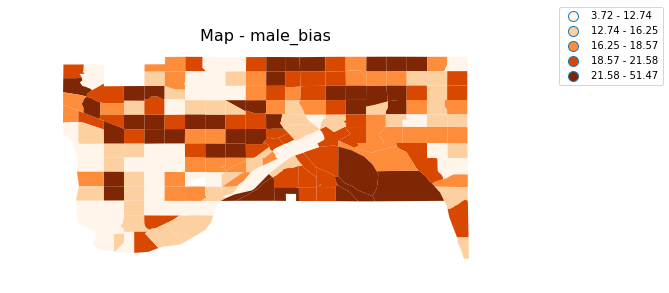

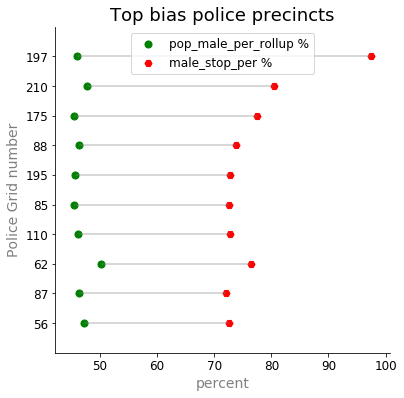

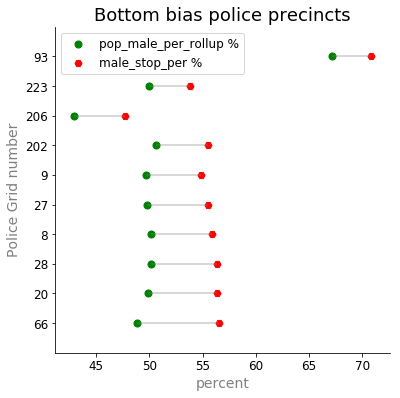

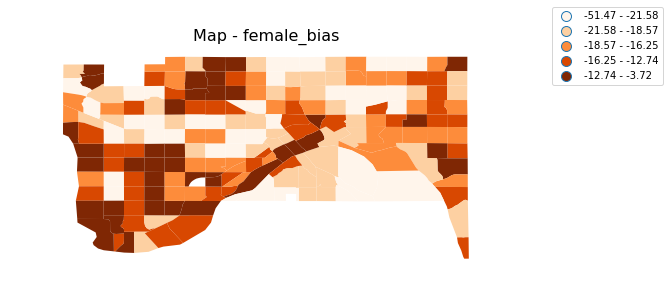

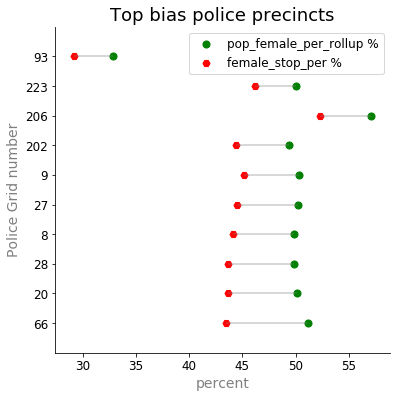

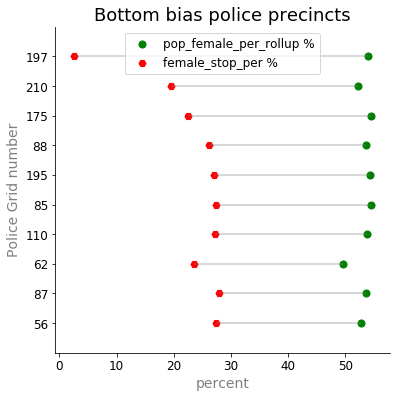

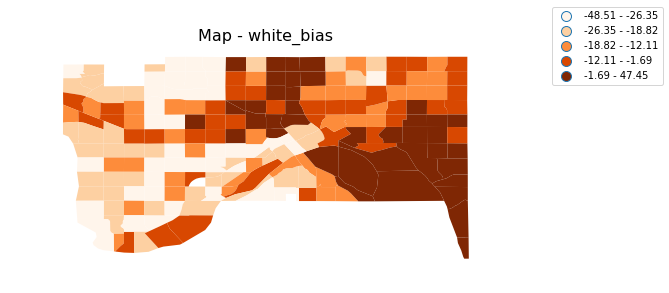

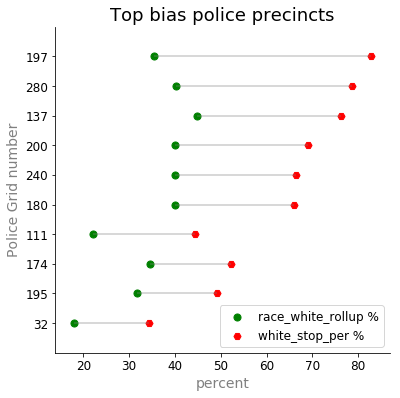

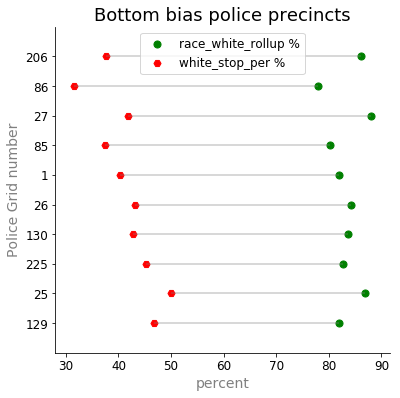

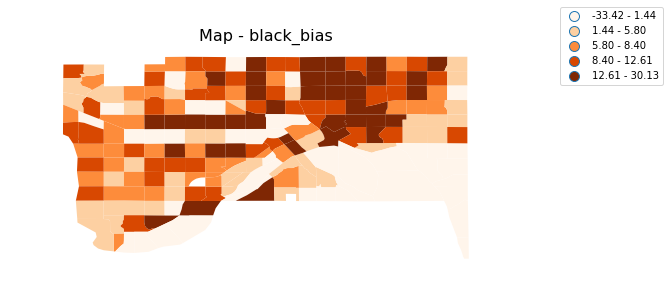

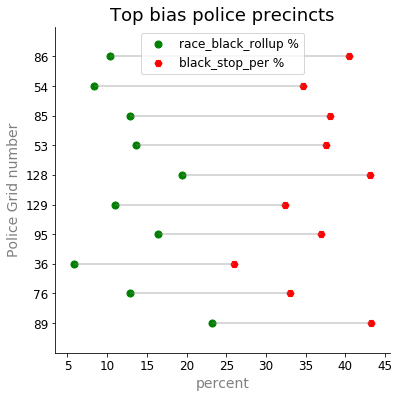

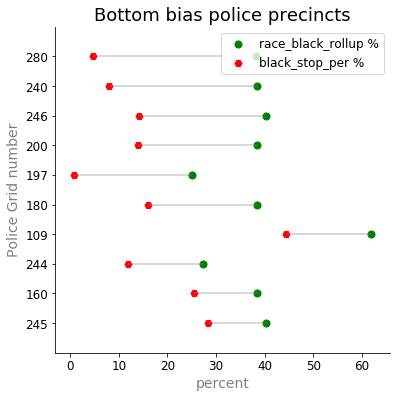

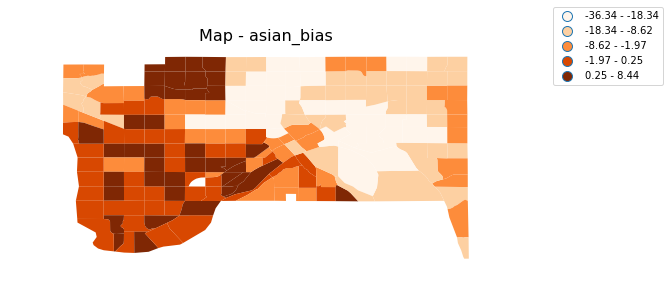

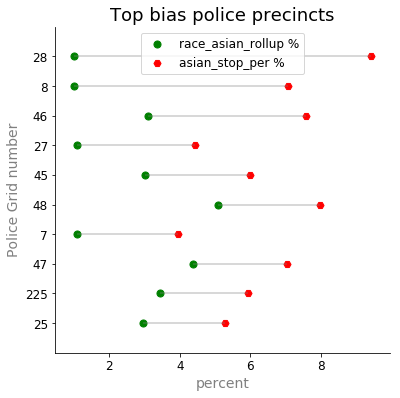

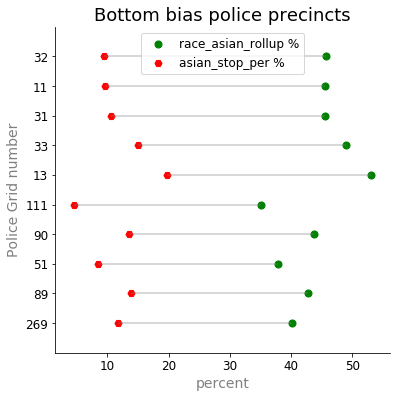

In [55]:
for col in np.arange(5,len(bias_df.columns),3):
    choropleth_map(bias_df,bias_df.columns[col],fsize = (8,8))
    t = bias_df.iloc[:,[0,col-2,col-1,col]].sort_values(by = bias_df.columns[col],ascending = False)
    cleveland_plot(xmins = t.iloc[:,2], 
               xmaxs=t.iloc[:,1], 
               ylabs =  t.gridnum, 
               chart_title =  'Top bias police precincts', 
               xmin_lab =  t.columns[2] + ' %', 
               xmax_lab =  t.columns[1] + ' %',
               ytitle = 'Police Grid number',
               xtitle = 'percent',
               fsize=(6,6))   
    t = bias_df.iloc[:,[0,col-2,col-1,col]].sort_values(by = bias_df.columns[col],ascending = True)
    cleveland_plot(xmins = t.iloc[:,2], 
               xmaxs=t.iloc[:,1], 
               ylabs =  t.gridnum, 
               chart_title =  'Bottom bias police precincts', 
               xmin_lab =  t.columns[2] + ' %', 
               xmax_lab =  t.columns[1] + ' %',
               ytitle = 'Police Grid number',
               xtitle = 'percent',
               fsize=(6,6))       

**Any relation between education level, poverty to vehicle stops?**

In [56]:
acs_police_record_by_pp.columns

Index(['dist', 'gridnum', 'geometry', 'center', 'total_stops', 'female_stops',
       'male_stops', 'gender_missing', 'asian', 'black', 'latino',
       'native_american', 'other', 'white', 'female_stop_per', 'male_stop_per',
       'asian_stop_per', 'black_stop_per', 'latino_stop_per',
       'native_american_stop_per', 'other_stop_per', 'white_stop_per',
       'pop_male_per_rollup', 'pop_female_per_rollup', 'race_white_rollup',
       'race_black_rollup', 'race_asian_rollup', 'edu_less_educated_rollup',
       'pov_below_poverty_rollup', 'emp_unemployment_rollup',
       'ooh_owneroccupied_rollup'],
      dtype='object')

In [57]:
relation_df = acs_police_record_by_pp.filter(items = ['gridnum',
                                                      'geometry',
                                                      'center',
                                                      'total_stops',
                                                      'edu_less_educated_rollup',
                                                      'pov_below_poverty_rollup',
                                                     'emp_unemployment_rollup',
                                                     'ooh_owneroccupied_rollup'])
relation_df

,gridnum,geometry,center,total_stops,edu_less_educated_rollup,pov_below_poverty_rollup,emp_unemployment_rollup,ooh_owneroccupied_rollup
0,82,POLYGON ((-93.18731873325051 44.95984522374139...,POINT (-93.19395572087154 44.9600741343416),220,3.992391,14.524849,3.103602,32.992654
1,62,"POLYGON ((-93.1891517284332 44.96150365239401,...",POINT (-93.19336389918618 44.96654212193393),1827,4.469407,33.590452,15.254952,13.209489
2,43,POLYGON ((-93.18726521154463 44.97865486589834...,POINT (-93.18534620032653 44.97307079688855),238,2.930122,23.064959,8.952719,35.499465
3,22,POLYGON ((-93.18723966266045 44.98348311651917...,POINT (-93.19279867382527 44.979647599681),142,1.779233,15.594429,4.401137,54.697180
4,63,POLYGON ((-93.18741336776411 44.96870629898084...,POINT (-93.18313010137743 44.96580346129455),2779,8.300681,26.078668,11.057543,46.554844
5,83,POLYGON ((-93.17720898176246 44.96283568196087...,POINT (-93.18220895058458 44.96033456290853),5748,4.475523,33.569749,15.243627,13.267126
6,103,POLYGON ((-93.18731873325051 44.95984522374139...,POINT (-93.18263266059699 44.95317795818605),2611,3.787476,16.778703,3.166882,39.470828
7,123,POLYGON ((-93.18735124913006 44.94837647963131...,POINT (-93.18226159195586 44.94492739389379),845,2.233641,18.114941,5.189752,51.897478
8,143,"POLYGON ((-93.17721658216813 44.9342893116616,...",POINT (-93.18228493380033 44.93789057885959),978,1.945029,22.032025,4.702116,53.177068
9,163,POLYGON ((-93.17720576551837 44.92702110877225...,POINT (-93.18229459278801 44.93066530055108),511,3.061990,6.071240,3.400425,74.537530


In [58]:
relation_df.iloc[:,3:].corr()

,total_stops,edu_less_educated_rollup,pov_below_poverty_rollup,emp_unemployment_rollup,ooh_owneroccupied_rollup
total_stops,1.000000,0.481316,0.472267,0.492360,-0.282823
edu_less_educated_rollup,0.481316,1.000000,0.826464,0.762405,-0.378028
pov_below_poverty_rollup,0.472267,0.826464,1.000000,0.817714,-0.649246
emp_unemployment_rollup,0.492360,0.762405,0.817714,1.000000,-0.491028
ooh_owneroccupied_rollup,-0.282823,-0.378028,-0.649246,-0.491028,1.000000


Total stops has positive correlation with less education, below poverty rate and unemployment rate while negative correlation with owner occupied housing. Also it is no surpise to see below poverty has strong positive correlation with less eduction, unemplyment rate and negative with owner occupied housing.

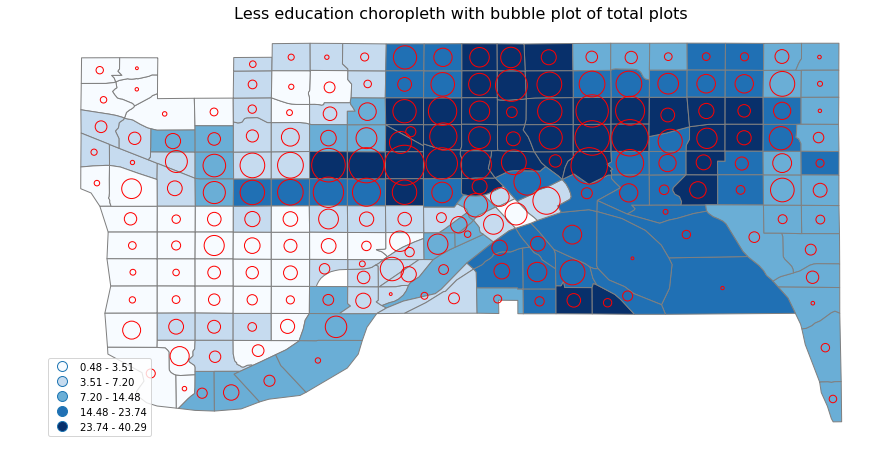

In [59]:
ax = relation_df.plot(edgecolor = 'gray', 
                      figsize = (15,15), 
                      column = 'edu_less_educated_rollup', 
                      scheme = 'quantiles',
                     legend = True,
                     cmap = 'Blues')
plt.scatter(x = relation_df['center'].apply(lambda x: Point(x).x),
           y = relation_df['center'].apply(lambda x: Point(x).y),
           s = relation_df['total_stops']/12,
           edgecolor = 'red',
           color = 'None')
ax.set_title('Less education choropleth with bubble plot of total plots', fontsize=16)
ax.set_axis_off()

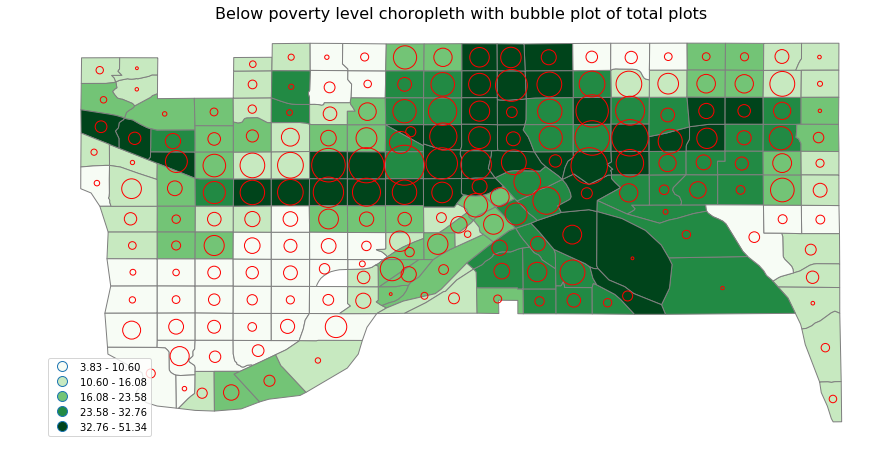

In [60]:
ax = relation_df.plot(edgecolor = 'gray', 
                      figsize = (15,15), 
                      column = 'pov_below_poverty_rollup', 
                      scheme = 'quantiles',
                     legend = True,
                     cmap = 'Greens')
plt.scatter(x = relation_df['center'].apply(lambda x: Point(x).x),
           y = relation_df['center'].apply(lambda x: Point(x).y),
           s = relation_df['total_stops']/12,
           edgecolor = 'red',
           color = 'None')
ax.set_title('Below poverty level choropleth with bubble plot of total plots', fontsize=16)
ax.set_axis_off()

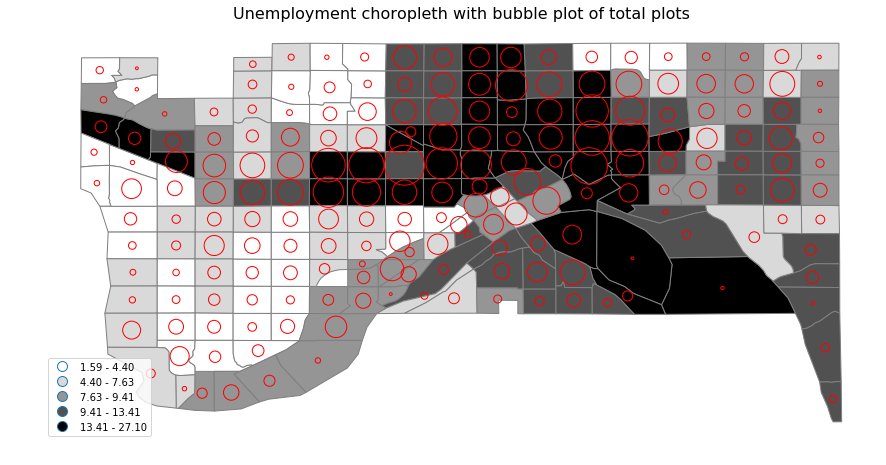

In [61]:
ax = relation_df.plot(edgecolor = 'gray', 
                      figsize = (15,15), 
                      column = 'emp_unemployment_rollup', 
                      scheme = 'quantiles',
                     legend = True,
                     cmap = 'Greys')
plt.scatter(x = relation_df['center'].apply(lambda x: Point(x).x),
           y = relation_df['center'].apply(lambda x: Point(x).y),
           s = relation_df['total_stops']/12,
           edgecolor = 'red',
           color = 'None')
ax.set_title('Unemployment choropleth with bubble plot of total plots', fontsize=16)
ax.set_axis_off()

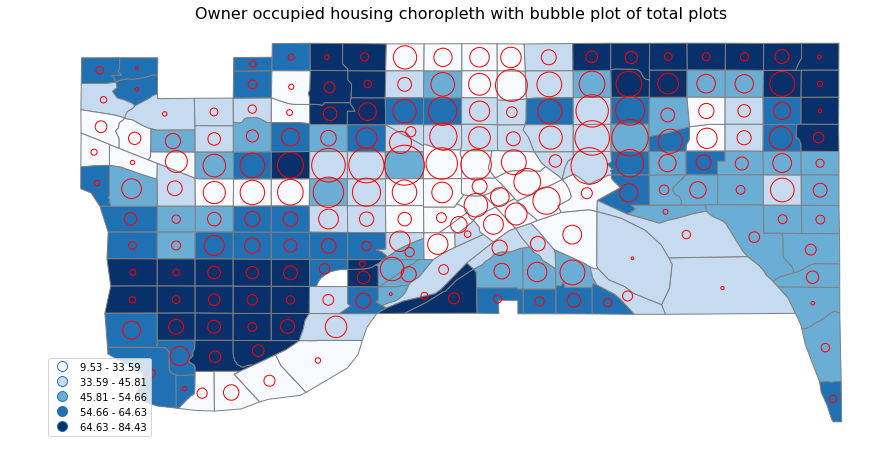

In [62]:
ax = relation_df.plot(edgecolor = 'gray', 
                      figsize = (15,15), 
                      column = 'ooh_owneroccupied_rollup', 
                      scheme = 'quantiles',
                     legend = True,
                     cmap = 'Blues')
plt.scatter(x = relation_df['center'].apply(lambda x: Point(x).x),
           y = relation_df['center'].apply(lambda x: Point(x).y),
           s = relation_df['total_stops']/12,
           edgecolor = 'red',
           color = 'None')
ax.set_title('Owner occupied housing choropleth with bubble plot of total plots', fontsize=16)
ax.set_axis_off()

## Are there any outliers or grouping??  

Let's use unsupervised clustering methods.


In [182]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

C:\Users\vandaleesh\Anaconda3\envs\folium on python3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


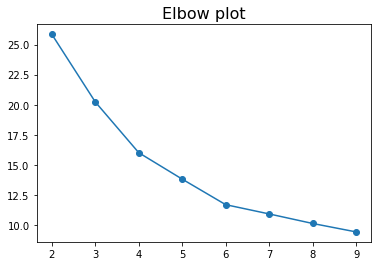

In [183]:
scale = MinMaxScaler()
relation_df_scaled = relation_df.iloc[:,3:8]
relation_df_scaled = scale.fit_transform(relation_df_scaled)
ranges = np.arange(2,10)
inert = []
for k in ranges:
    model = KMeans(n_clusters = k)
    model.fit(relation_df_scaled)
    inert.append(model.inertia_)

plt.plot(ranges,inert,'-o')
plt.xticks(ranges)
plt.title('Elbow plot', fontsize = 16, loc = 'center')
plt.show()

In [184]:
good_model = KMeans(n_clusters =6)
good_model.fit(relation_df_scaled)
relation_df['cluster_scaled'] = good_model.predict(relation_df_scaled)

Principal Component Analysis is used for visualising of police precincts clustered.

In [239]:
pca = PCA(n_components = 2)
t = pca.fit_transform(relation_df_scaled)
pca_df = pd.DataFrame(data = t, columns = ['PCA1','PCA2'])
pca_df = pd.concat([pca_df,relation_df['cluster_scaled']],axis=1)

Clustering visualization

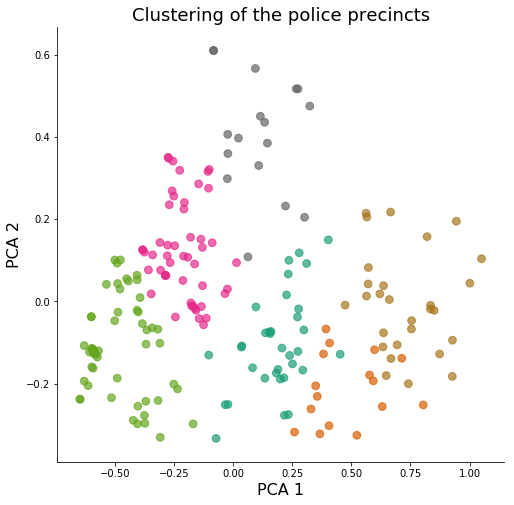

In [240]:
fig, ax = plt.subplots(figsize= (8,8))
plt.scatter(pca_df.PCA1,pca_df.PCA2,c = pca_df.cluster_scaled,s=60, alpha = 0.7, cmap = 'Dark2')
plt.title('Clustering of the police precincts', fontsize = 18)
plt.xlabel('PCA 1', fontsize =16)
plt.ylabel('PCA 2', fontsize =16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Top of the chart seems to have some outliers in gray color. To find out the police precincts, use annotation. though it will crowd the chart.

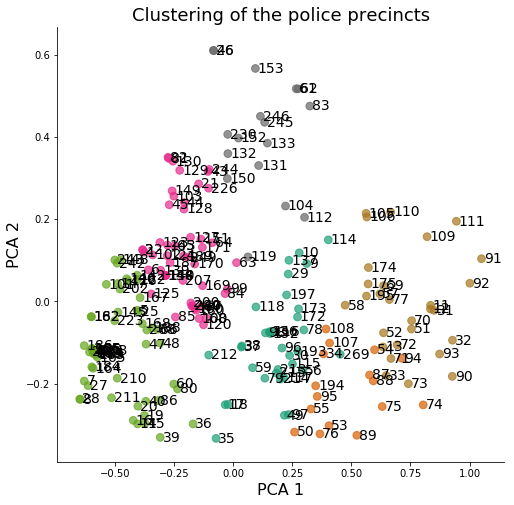

In [241]:
fig, ax = plt.subplots(figsize= (8,8))
plt.scatter(pca_df.PCA1,pca_df.PCA2,c = pca_df.cluster_scaled,s=60, alpha = 0.7, cmap = 'Dark2')
plt.title('Clustering of the police precincts', fontsize = 18)
plt.xlabel('PCA 1', fontsize =16)
plt.ylabel('PCA 2', fontsize =16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i, pp in enumerate(relation_df.gridnum):
    ax.annotate(pp,(pca_df.PCA1[i]+0.01,pca_df.PCA2[i]-0.01),fontsize=14)

26, 46 153 seems to be outliers. Looking at clusters in PCA view does not seem clear 6 clusters. May be 4 is better??
Now let's check how these clustering are spreadout geospatially.

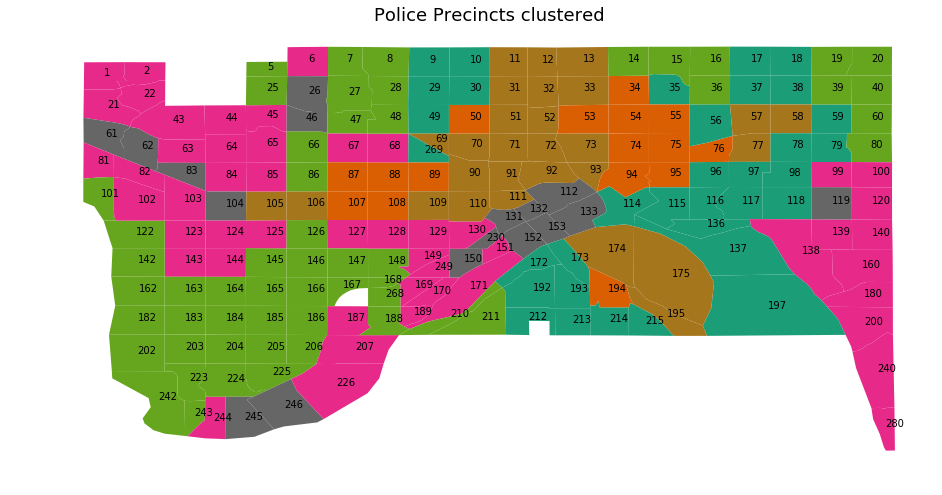

In [244]:
ax = relation_df.plot(column = 'cluster_scaled',figsize = (16,16),cmap='Dark2')
ax.set_axis_off()
ax.set_title('Police Precincts clustered', fontsize = 18)

for i, pp in enumerate(relation_df.gridnum):
    ax.annotate(pp,(relation_df.geometry[i].centroid.x, relation_df.geometry[i].centroid.y))